In [5]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import common_evaluation


# Download NLTK resources (only needs to be done once)
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Load Data and Models

In [6]:
# Paths to multilingual FastText aligned vectors (.vec files)
fasttext_model_paths = {
    'en': 'pretrained_models/fasttext/wiki.en.align.vec',
    'es': 'pretrained_models/fasttext/wiki.es.align.vec',
    'de': 'pretrained_models/fasttext/wiki.de.align.vec',
    'pl': 'pretrained_models/fasttext/wiki.pl.align.vec',
    'tr': 'pretrained_models/fasttext/wiki.tr.align.vec',
    'ar': 'pretrained_models/fasttext/wiki.ar.align.vec',
    'fr': 'pretrained_models/fasttext/wiki.fr.align.vec'
}

# Load and cache gensim models
fasttext_models = {}
for lang, path in fasttext_model_paths.items():
    print(f"Loading FastText model for {lang}...")
    fasttext_models[lang] = KeyedVectors.load_word2vec_format(path)

Loading FastText model for en...
Loading FastText model for es...
Loading FastText model for de...
Loading FastText model for pl...
Loading FastText model for tr...
Loading FastText model for ar...
Loading FastText model for fr...


## Step 1: Basic preprocessing

In [7]:
def simple_preprocess(text):
    if not isinstance(text, str):
        text = ""
    return word_tokenize(text.lower())

## Step 2: Compute average word embedding for a document

In [8]:
def average_embedding(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

## Step 3: Compute cosine similarity between two vectors

In [9]:
def compute_similarity(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]

## Step 4: Convert similarity score to class label (0 to 3)

In [10]:
def classify_similarity(sim):
    if sim >= 0.90:
        return 4
    elif sim >= 0.75:
        return 3
    elif sim >= 0.50:
        return 2
    else:
        return 1

## Main comparison function

In [11]:
def compare_articles(text_a, text_b, lang_a, lang_b, models_dict):
    tokens_a = simple_preprocess(text_a)
    tokens_b = simple_preprocess(text_b)

    model_a = models_dict.get(lang_a)
    model_b = models_dict.get(lang_b)

    if model_a is None or model_b is None:
        return 0.0, 1  # fallback für fehlendes Modell

    vec_a = average_embedding(tokens_a, model_a)
    vec_b = average_embedding(tokens_b, model_b)

    sim = compute_similarity(vec_a, vec_b)
    label = classify_similarity(sim)

    return sim, label

## Classification Prediction

In [12]:
def predict_classification(X):
    predictions = []

    for _, row in X.iterrows():
        text_a = str(row['title1']) + " " + str(row['text1'])
        text_b = str(row['title2']) + " " + str(row['text2'])
        lang_a = row['lang1']
        lang_b = row['lang2']

        sim, label = compare_articles(text_a, text_b, lang_a, lang_b, fasttext_models)
        predictions.append(label)

    return predictions

## Regression Prediction

In [13]:
def predict_regression(X):
    predictions = []

    for _, row in X.iterrows():
        text_a = str(row['title1']) + " " + str(row['text1'])
        text_b = str(row['title2']) + " " + str(row['text2'])
        lang_a = row['lang1']
        lang_b = row['lang2']

        sim, label = compare_articles(text_a, text_b, lang_a, lang_b, fasttext_models)
        # Rescale from [0, 1] → [1, 4]
        sim_rescaled = 1 + sim * 3
        predictions.append(sim_rescaled)

    return predictions

# Evaluate with Test Data

In [14]:
test_df = pd.read_csv("test_data/test_dataset.csv")

test_y_true = test_df["overall"]
test_y_true_classification = test_df["overall_classification"]

test_X = test_df.drop(columns=[
    "overall",
    "overall_classification",
    "geography", "entities", "time", "narrative", "style", "tone"
])


Classification Evaluation for Word Embeddings Multilingual - Cosine Similarity (Classifier)
Accuracy: 0.226
Precision (weighted): 0.243
Recall (weighted): 0.226
F1 Score (weighted): 0.178

Classification Report:
              precision    recall  f1-score   support

           1      0.213     0.455     0.290       970
           2      0.304     0.008     0.015       885
           3      0.203     0.043     0.071       700
           4      0.246     0.315     0.276      1121

    accuracy                          0.226      3676
   macro avg      0.242     0.205     0.163      3676
weighted avg      0.243     0.226     0.178      3676



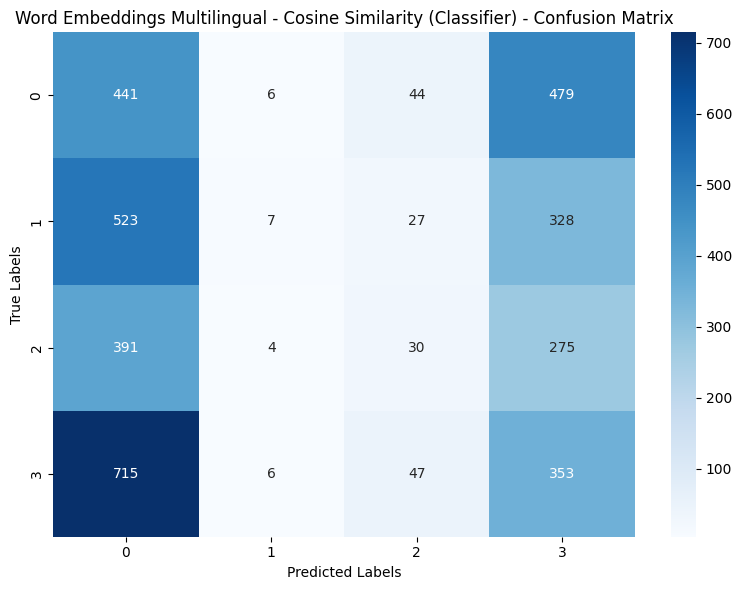

Results saved to: eval_results\word_multilingual_cosine_classification.json


In [15]:
test_y_pred = predict_classification(test_X)
results = common_evaluation.evaluate_classification(test_y_true_classification, test_y_pred, description="Word Embeddings Multilingual - Cosine Similarity (Classifier)", save_json_file_name="word_multilingual_cosine_classification.json")


Regression Evaluation for Word Embeddings Multilingual - Cosine Similarity (Regression)
Mean Squared Error (MSE): 3.729
Mean Absolute Error (MAE): 1.589
R2 Score: -1.719


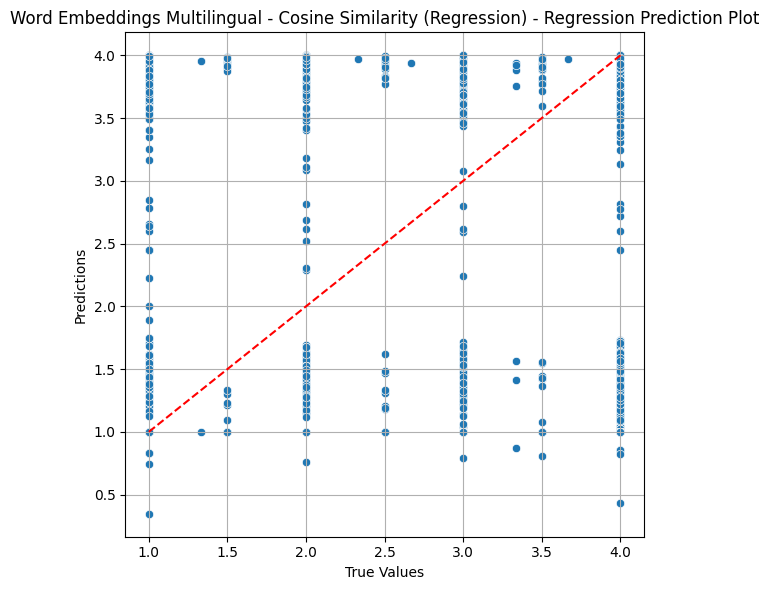

Results saved to: eval_results\word_multilingual_cosine_regression.json


In [16]:
test_y_pred = predict_regression(test_X)
results = common_evaluation.evaluate_regression(test_y_true, test_y_pred, description="Word Embeddings Multilingual - Cosine Similarity (Regression)", save_json_file_name="word_multilingual_cosine_regression.json")

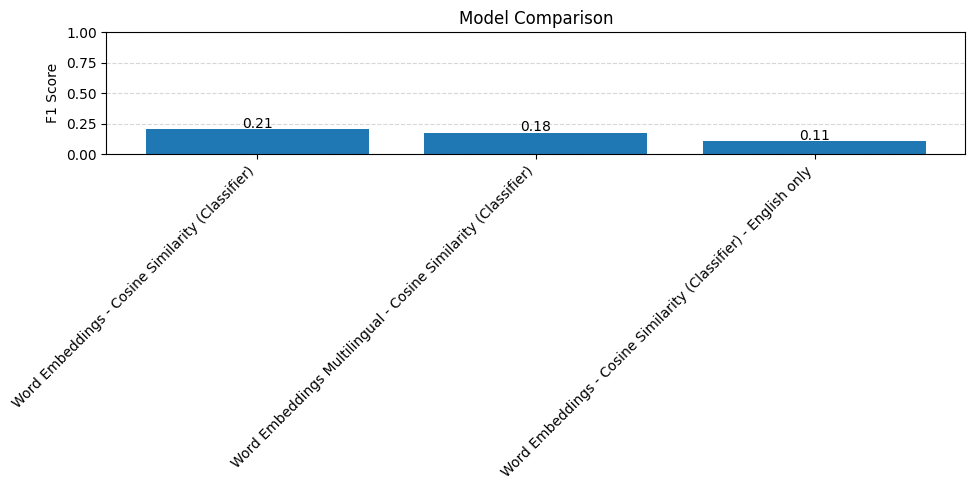

In [ ]:
df = common_evaluation.load_all_results()
common_evaluation.plot_model_comparison(df, metric="Accuracy")